In [5]:
!pwd

/content


In [6]:
!ls

deeplearning_model.py  sample_data


# CNN卷积神经网络

In [7]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from deeplearning_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from deeplearning_model import evaluate_classification_model as evaluate_model
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
print(train_dataset[0])
train_dataset[0][0]

100%|██████████| 26.4M/26.4M [00:02<00:00, 13.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.91MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 863kB/s]


(<PIL.Image.Image image mode=L size=28x28 at 0x7873571838D0>, 9)


# 加载数据并处理为tensor格式

In [8]:
# 加载Fashion MNIST数据集，张量就是和numpy数组一样
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.286,), (0.353,))
])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


# 获取图像和标签
# 注意：由于使用了transform，图像已经被转换为张量且标准化
# 我们需要从dataset中提取原始图像用于显示
train_images = train_dataset.data.numpy()
train_labels = train_dataset.targets.numpy()
test_images = test_dataset.data.numpy()
test_labels = test_dataset.targets.numpy()

# 定义类别名称标签
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 查看数据集基本信息
print(f"训练集形状: {train_images.shape}")
print(f"训练集标签数量: {len(train_labels)}")
print(f"测试集形状: {test_images.shape}")
print(f"测试集标签数量: {len(test_labels)}")

训练集形状: (60000, 28, 28)
训练集标签数量: 60000
测试集形状: (10000, 28, 28)
测试集标签数量: 10000


In [9]:
# 计算训练集均值和方差，以便加载数据集时直接标准化
def calculate_mean_std(train_dataset):
    # 首先将所有图像数据堆叠为一个大张量
    all_images = torch.stack([img_tensor for img_tensor, _ in train_dataset])
    print(all_images.shape)
    # 计算通道维度上的均值和标准差
    # Fashion MNIST是灰度图像，只有一个通道
    # 对所有像素值计算均值和标准差
    mean = torch.mean(all_images)
    std = torch.std(all_images)

    print(f"训练数据集均值: {mean.item():.4f}")
    print(f"训练数据集标准差: {std.item():.4f}")

    # 检查数据集大小
    print(f"数据集中图像总数: {len(train_dataset)}")

# calculate_mean_std(train_dataset)

In [10]:

# 划分训练集，验证集，测试集
from traceback import print_exception


train_size = int(len(train_dataset) * 0.64)
val_size = int(len(train_dataset) * 0.16)
test_size = len(train_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size, test_size],generator=torch.Generator().manual_seed(42)
)

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)


# 定义CNN模型类

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class CNN(nn.Module):
    """
    CNN卷积神经网络模型
    卷积核数量由32依次递增
    使用Xavier均匀分布初始化权重
    """
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # 第一个卷积层: 1通道输入，32通道输出，卷积核大小3x3，padding=1表示填充1个像素，使输出尺寸与输入尺寸相同
        # self.conv1和self.conv2共同构成一个卷积块，起到提取高维特征的作用
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        # 第二个卷积层: 32通道输入，64通道输出，卷积核大小3x3
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        # 第三个卷积层: 64通道输入，128通道输出，卷积核大小3x3
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        # 池化层
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 全连接层
        # 经过3次池化，图像尺寸变为原来的1/8，即28/8≈3
        # 128个通道，每个通道3x3大小
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 10)

        # Dropout层，防止过拟合
        self.dropout = nn.Dropout(0.5)

        # 初始化权重
        self._initialize_weights()

    def forward(self, x):

        # 第一个卷积块
        x = self.conv1(x)
        # print(f"第一次卷积后形状: {x.shape}")[64, 32, 28, 28]
        x = F.relu(self.conv2(x))
        # print(f"第一次ReLU后形状: {x.shape}")
        x = self.pool(x)
        # print(f"第一次池化后形状: {x.shape}")  # 输出尺寸: 14x14

        # 第二个卷积块
        x = self.conv3(x)
        # print(f"第二次卷积后形状: {x.shape}") [64, 64, 14, 14]
        x = F.relu(self.conv4(x))
        # print(f"第二次ReLU后形状: {x.shape}")
        x = self.pool(x)
        # print(f"第二次池化后形状: {x.shape}")  # 输出尺寸: 7x7

        # 第三个卷积块
        x = self.conv5(x)
        # print(f"第三次卷积后形状: {x.shape}") [64, 128, 7, 7]
        x = F.relu(self.conv6(x))
        # print(f"第三次ReLU后形状: {x.shape}")
        x = self.pool(x)
        # print(f"第三次池化后形状: {x.shape}")  # 输出尺寸: 3x3

        # 展平操作
        x = x.view(-1, 128 * 3 * 3)
        # print(f"展平后形状: {x.shape}")

        # 全连接层
        x = self.fc1(x)
        x = F.relu(x)
        # print(f"fc1全连接ReLU后形状: {x.shape}")
        x = self.dropout(x)
        # print(f"Dropout后形状: {x.shape}")
        x = self.fc2(x)
        # print(f"输出层形状: {x.shape}")

        return x

    def _initialize_weights(self):
        """
        使用Xavier均匀分布初始化权重
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # 卷积层使用Xavier均匀分布初始化
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # 全连接层使用Xavier均匀分布初始化
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0)


In [12]:
# 实例化模型
model = CNN()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)

批次图像形状: torch.Size([64, 1, 28, 28])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------


In [13]:
# 查看模型参数数量parameters接口是nn.Module的属性，返回一个生成器，生成器中的每个元素是一个参数的元组，元组中第一个元素是参数，第二个元素是参数的名称
next(model.parameters()).numel()

288

In [14]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")

# model.state_dict() 返回一个字典，字典的键是参数的名称，值是参数的值

需要求梯度的参数总量: 584170
模型总参数量: 584170

各层参数量明细:
conv1.weight: 288 参数
conv1.bias: 32 参数
conv2.weight: 9216 参数
conv2.bias: 32 参数
conv3.weight: 18432 参数
conv3.bias: 64 参数
conv4.weight: 36864 参数
conv4.bias: 64 参数
conv5.weight: 73728 参数
conv5.bias: 128 参数
conv6.weight: 147456 参数
conv6.bias: 128 参数
fc1.weight: 294912 参数
fc1.bias: 256 参数
fc2.weight: 2560 参数
fc2.bias: 10 参数


# 设置交叉熵损失函数，SGD优化器

In [15]:
model = CNN()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码
# 用少量样本就能更新权重，训练更快，且更容易跳出局部最优,动量为0.9的含义指，当前的梯度是上一次的梯度乘以0.9加上当前的梯度乘以0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9


In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #如果GPU可用，则使用GPU，否则使用CPU
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU与训练模型，评估模型，保存模型中相同
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)

model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver)


使用设备: cuda:0
训练开始，共30000步


  0%|          | 0/30000 [00:00<?, ?it/s]

早停触发!
92.1354
早停: 在27000 步


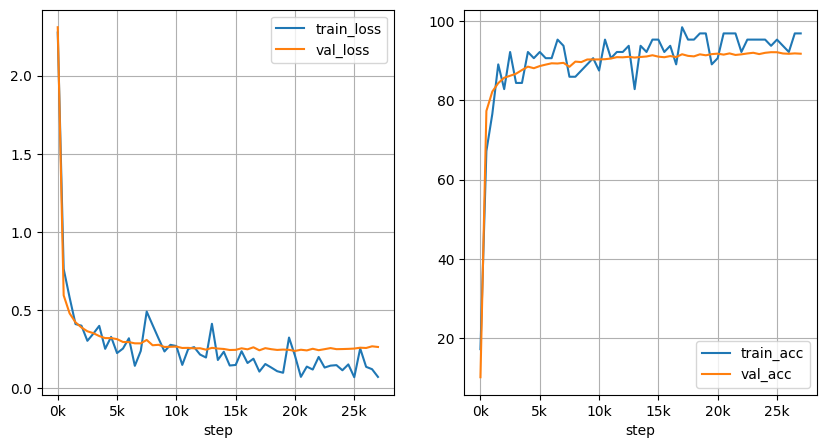

In [17]:
# 绘制学习损失曲线，sample_step是每500步绘制一次
plot_learning_curves(history, sample_step=500)  #横坐标是 steps，纵坐标是 loss，accuracy

In [18]:
# 在测试集上评估模型
test_accuracy = evaluate_model(model, test_loader, device, loss_fn)
test_accuracy

(91.65, 0.2609978940834602)